# Malaysia Power – CO₂ Emissions

This notebook joins generation data with emission factors to estimate
monthly CO₂ emissions in tonnes, both by fuel and in total.


In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

con = sqlite3.connect("/Users/praabz/Desktop/Malaysia power sql lab/malaysia_power.db")

pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", con)


,name
0,sqlite_stat1
1,sqlite_stat4
2,dim_date_month
3,dim_region
4,dim_fuel
5,emission_factor
6,fact_demand_monthly
7,fact_generation_monthly
8,fuel_price_monthly


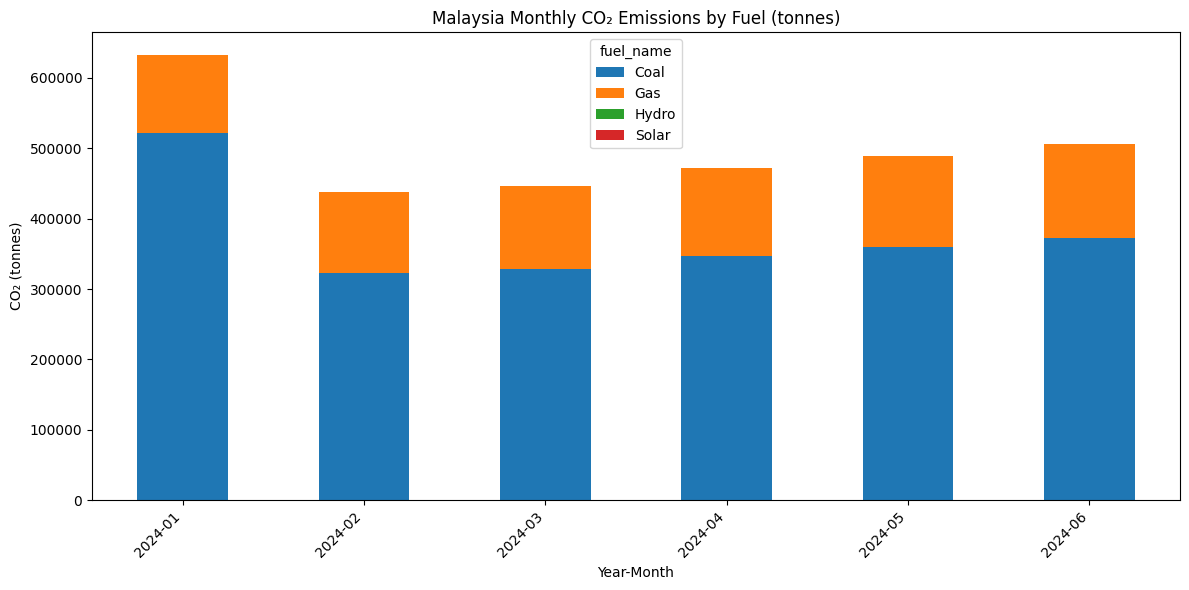

In [5]:
query = """
SELECT
    d.year,
    d.month,
    f.fuel_name,
    SUM(g.mwh * e.kg_co2_per_mwh) / 1000.0 AS co2_tonnes
FROM fact_generation_monthly g
JOIN dim_date_month d ON g.date_id = d.date_id
JOIN dim_fuel f        ON g.fuel_id = f.fuel_id
JOIN emission_factor e ON g.fuel_id = e.fuel_id
GROUP BY
    d.year,
    d.month,
    f.fuel_name
ORDER BY
    d.year,
    d.month,
    f.fuel_name;
"""

df = pd.read_sql(query, con)

pivot = df.pivot_table(
    index=["year", "month"],
    columns="fuel_name",
    values="co2_tonnes",
    fill_value=0
)

pivot.index = pivot.index.map(lambda x: f"{x[0]}-{x[1]:02d}")

ax = pivot.plot(kind="bar", stacked=True, figsize=(12, 6))
ax.set_title("Malaysia Monthly CO₂ Emissions by Fuel (tonnes)")
ax.set_xlabel("Year-Month")
ax.set_ylabel("CO₂ (tonnes)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


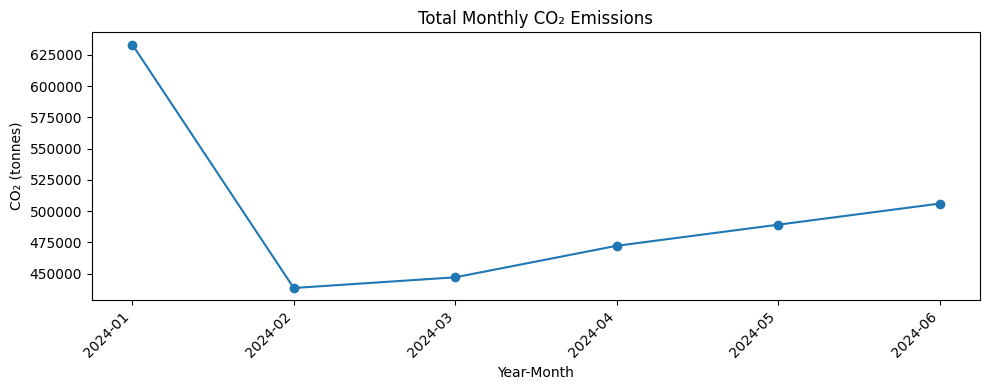

In [8]:
# Optional: total emissions line

# Group to total CO₂ per month
total = df.groupby(["year", "month"], as_index=False)["co2_tonnes"].sum()

# Build YYYY-MM string safely (no apply)
total["year_month"] = (
    total["year"].astype(str) + "-" + total["month"].astype(str).str.zfill(2)
)

plt.figure(figsize=(10, 4))
plt.plot(total["year_month"], total["co2_tonnes"], marker="o")
plt.title("Total Monthly CO₂ Emissions")
plt.xlabel("Year-Month")
plt.ylabel("CO₂ (tonnes)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
